<center><h1>Ensemble Model</h1></center>
Combining Two models, One trained to identify class 1 with high precision and other to identify class 0 with high precision. Individually, they have low performance, but when combined they deliver high performance. We also get to know with certainty that all the samples predicted by Model 1 as class 1 are indeed very likely class 1 and all the samples predicted by Model 2 as class 0 are indeed very likely class 0.

In [ ]:
# Model 1 : High Precision for class 1 | XGB Classifier | Low overall performance
# Model 2 : High Precision for class 0 | Neural Network | Low overall performance
# Meta Model : Balanced Precision | Neural Network | High overall performance (Combines Model 1 and Model 2)

# 1. Import Requirements

In [1]:
import hashlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from joblib import dump, load

2024-09-23 18:42:33.530810: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 18:42:33.554150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 18:42:33.579980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 18:42:33.587735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 18:42:33.608162: I tensorflow/core/platform/cpu_feature_guar

# 2. Load Original Dataset and Perform Integrity Check

## A. Define File Paths

In [2]:
# Make sure that the respective csv files are in the train and test folders.
x_train_csv_path = 'dataset_original/Train_60/X_Train_Data_Input.csv'
y_train_csv_path = 'dataset_original/Train_60/Y_Train_Data_Target.csv'
x_test_csv_path = 'dataset_original/Test_20/X_Test_Data_Input.csv'
y_test_csv_path = 'dataset_original/Test_20/Y_Test_Data_Target.csv'

## B. Integrity Check

In [3]:
def calculate_checksum(file_path, hash_algorithm='sha256'):
    try:
        hash_func = hashlib.new(hash_algorithm)
        with open(file_path, 'rb') as file:
            while chunk := file.read(8192):
                hash_func.update(chunk)
        return hash_func.hexdigest()
    except FileNotFoundError:
        return f"Error: File '{file_path}' not found."
    except ValueError:
        return f"Error: Invalid hash algorithm '{hash_algorithm}'."
    except Exception as e:
        return f"Error: {str(e)}"

In [4]:
flag = True

checksum = calculate_checksum(x_train_csv_path)
if checksum == '5e4871f01f3aa565aaee0fda58868046ff20c3e5d9084c3edc2c1f33ab97497b':
    print('1) Success: X_Train_Data_Input.csv file is valid')
else:
    print('1) Error: X_Train_Data_Input.csv file is CORRUPTED')
    flag = False

checksum = calculate_checksum(y_train_csv_path)
if checksum == '986eb33c09f9d275b36c1c06fa05de4a06bd9413ab5ed9986fe0f82c66ccf3c8':
    print('2) Success: Y_Train_Data_Target.csv file is valid')
else:
    print('2) Error: Y_Train_Data_Target.csv file is CORRUPTED')
    flag = False

checksum = calculate_checksum(x_test_csv_path)
if checksum == '4def397cabaf0fee6bb34fc47a48d2056a2b33eabb62c32794b6cb96abee8b89':
    print('3) Success: X_Test_Data_Input.csv file is valid')
else:
    print('3) Error: X_Test_Data_Input.csv file is CORRUPTED')
    flag = False

checksum = calculate_checksum(y_test_csv_path)
if checksum == '9857969bc83f591bba87394fb38aeb1ad966f84d4b44534f5f17acb2a9313793':
    print('4) Success: Y_Test_Data_Target.csv file is valid')
else:
    print('4) Error: Y_Test_Data_Target.csv file is CORRUPTED')
    flag = False

if flag:
    print('ALL FILES ARE VALID')
else:
    print('!!WARNING: one or more files are corrupted!!')

1) Success: X_Train_Data_Input.csv file is valid
2) Success: Y_Train_Data_Target.csv file is valid
3) Success: X_Test_Data_Input.csv file is valid
4) Success: Y_Test_Data_Target.csv file is valid
ALL FILES ARE VALID


## C. Load the Dataset

In [5]:
# Load the datasets
X_train = pd.read_csv(x_train_csv_path)
Y_train = pd.read_csv(y_train_csv_path)
X_test = pd.read_csv(x_test_csv_path)
Y_test = pd.read_csv(y_test_csv_path)

# Print the shapes of the datasets
print(f"\nShape of X_Train: {X_train.shape}")
print(f"Shape of Y_Train: {Y_train.shape}")
print(f"Shape of X_Test: {X_test.shape}")
print(f"Shape of Y_Test: {Y_test.shape}")

# Visualize the data
print("Training Data Overview:")
print(X_train.head())
print("\nTraining Target Overview:")
print(Y_train.head())


Shape of X_Train: (785133, 23)
Shape of Y_Train: (785133, 2)
Shape of X_Test: (261712, 23)
Shape of Y_Test: (261712, 2)
Training Data Overview:
                                 ID  Column0  Column1  Column2   Column3  \
0  ad1a67e4cbddc767a3456b0d94299b9e      2.0     2495   3726.0  0.678139   
1  7246d2f76ac0c217ec25e72ea5f014cb      0.0     2495   3454.0  0.452580   
2  22ba388e7dd14c13342c49e75fc29dda      2.0     2495   4543.0 -1.577453   
3  59f9b981472d97342587fb3e6392aeb1      0.0      211     59.0       NaN   
4  f6317cf7ecf126859804eddff279aead      0.0      718    950.0 -2.028572   

    Column4   Column5   Column6   Column7   Column8  ...  Column12  Column13  \
0  0.701403 -0.007468  0.434190 -0.015603  0.606265  ...         0         0   
1  0.701403 -0.007468  1.554998 -0.015574  0.329946  ...         0         0   
2 -1.429540 -0.007469 -0.407939 -0.015607 -0.774979  ...         1         1   
3       NaN       NaN -0.407939 -0.015607 -0.774979  ...         0         0  

# 3. Dataset Preprocessing

## A. Drop the ID column

In [6]:
# Drop the 'ID' column (as it's not useful for training)
X_train.drop(columns=['ID'], inplace=True)
Y_train.drop(columns=['ID'], inplace=True)
X_test.drop(columns=['ID'], inplace=True)
Y_test.drop(columns=['ID'], inplace=True)

## B. Cap the Outliers

In [7]:
# Cap the outliers in train set
cap_dict = {}

#-------------------------------------------------------------------------------
# Column5
column_name = 'Column5'
lower_cap = None
upper_cap = X_train[column_name].quantile(0.9999)
print(column_name)
print(f'lower_cap={lower_cap}')
print(f'upper_cap={upper_cap}')

# Apply capping: values below lower_cap are set to lower_cap, values above upper_cap are set to upper_cap
X_train[column_name] = np.clip(X_train[column_name], lower_cap, upper_cap)

# Save to dictionary
cap_dict[column_name] = (lower_cap, upper_cap)

#-------------------------------------------------------------------------------
# Column6
column_name = 'Column6'
lower_cap = None
upper_cap = X_train[column_name].quantile(0.9999)
print(column_name)
print(f'lower_cap={lower_cap}')
print(f'upper_cap={upper_cap}')

# Apply capping: values below lower_cap are set to lower_cap, values above upper_cap are set to upper_cap
X_train[column_name] = np.clip(X_train[column_name], lower_cap, upper_cap)

# Save to dictionary
cap_dict[column_name] = (lower_cap, upper_cap)

#-------------------------------------------------------------------------------
# Column7
column_name = 'Column7'
lower_cap = None
upper_cap = X_train[column_name].quantile(0.9999)
print(column_name)
print(f'lower_cap={lower_cap}')
print(f'upper_cap={upper_cap}')

# Apply capping: values below lower_cap are set to lower_cap, values above upper_cap are set to upper_cap
X_train[column_name] = np.clip(X_train[column_name], lower_cap, upper_cap)

# Save to dictionary
cap_dict[column_name] = (lower_cap, upper_cap)

#-------------------------------------------------------------------------------
# Column8
column_name = 'Column8'
lower_cap = None
upper_cap = X_train[column_name].quantile(0.9999)
print(column_name)
print(f'lower_cap={lower_cap}')
print(f'upper_cap={upper_cap}')

# Apply capping: values below lower_cap are set to lower_cap, values above upper_cap are set to upper_cap
X_train[column_name] = np.clip(X_train[column_name], lower_cap, upper_cap)

# Save to dictionary
cap_dict[column_name] = (lower_cap, upper_cap)

#-------------------------------------------------------------------------------
# Column9
column_name = 'Column9'
lower_cap = None
upper_cap = X_train[column_name].quantile(0.999)
print(column_name)
print(f'lower_cap={lower_cap}')
print(f'upper_cap={upper_cap}')

# Apply capping: values below lower_cap are set to lower_cap, values above upper_cap are set to upper_cap
X_train[column_name] = np.clip(X_train[column_name], lower_cap, upper_cap)

# Save to dictionary
cap_dict[column_name] = (lower_cap, upper_cap)

#-------------------------------------------------------------------------------
# Column14
column_name = 'Column14'
lower_cap = X_train[column_name].quantile(0.001)
upper_cap = X_train[column_name].quantile(0.999)
print(column_name)
print(f'lower_cap={lower_cap}')
print(f'upper_cap={upper_cap}')

# Apply capping: values below lower_cap are set to lower_cap, values above upper_cap are set to upper_cap
X_train[column_name] = np.clip(X_train[column_name], lower_cap, upper_cap)

# Save to dictionary
cap_dict[column_name] = (lower_cap, upper_cap)

#-------------------------------------------------------------------------------
# Column15
column_name = 'Column15'
lower_cap = X_train[column_name].quantile(0.001)
upper_cap = X_train[column_name].quantile(0.999999)
print(column_name)
print(f'lower_cap={lower_cap}')
print(f'upper_cap={upper_cap}')

# Apply capping: values below lower_cap are set to lower_cap, values above upper_cap are set to upper_cap
X_train[column_name] = np.clip(X_train[column_name], lower_cap, upper_cap)

# Save to dictionary
cap_dict[column_name] = (lower_cap, upper_cap)

#-------------------------------------------------------------------------------
# Column17
column_name = 'Column17'
lower_cap = None
upper_cap = 120
print(column_name)
print(f'lower_cap={lower_cap}')
print(f'upper_cap={upper_cap}')

# Apply capping: values below lower_cap are set to lower_cap, values above upper_cap are set to upper_cap
X_train[column_name] = np.clip(X_train[column_name], lower_cap, upper_cap)

# Save to dictionary
cap_dict[column_name] = (lower_cap, upper_cap)

Column5
lower_cap=None
upper_cap=10.880524016040438
Column6
lower_cap=None
upper_cap=3.440526788922186
Column7
lower_cap=None
upper_cap=45.36292569302045
Column8
lower_cap=None
upper_cap=13.786297944822405
Column9
lower_cap=None
upper_cap=10.478853569536852
Column14
lower_cap=0.001242022717049515
upper_cap=0.001370555723753345
Column15
lower_cap=-0.23901038570283042
upper_cap=0.007882046956824504
Column17
lower_cap=None
upper_cap=120


In [8]:
# Save the cap_dict for future use:
dump(cap_dict, 'preprocessing_config/cap_dict.joblib')

['preprocessing_config/cap_dict.joblib']

In [9]:
# Caping/Binning the test dataset
cap_dict = load('preprocessing_config/cap_dict.joblib')
for col in cap_dict:
    print(f'{col} : low= {cap_dict[col][0]} | high= {cap_dict[col][1]}')
    X_test[col] = np.clip(X_test[col], cap_dict[col][0], cap_dict[col][1])

Column5 : low= None | high= 10.880524016040438
Column6 : low= None | high= 3.440526788922186
Column7 : low= None | high= 45.36292569302045
Column8 : low= None | high= 13.786297944822405
Column9 : low= None | high= 10.478853569536852
Column14 : low= 0.001242022717049515 | high= 0.001370555723753345
Column15 : low= -0.23901038570283042 | high= 0.007882046956824504
Column17 : low= None | high= 120


## C. Feature Engineering
Adding Features Manually

In [10]:
# Add extra features for indicating if the value in that column was NA before imputation or if that value is the most frequent one.
X_train['Column9_NA'] = X_train['Column9'].isna().astype(int)

X_train['Column14_NA'] = X_train['Column14'].isna().astype(int)

most_frequent_value_15 = X_train['Column15'].mode()[0]
X_train['Column15_Frequent'] = (X_train['Column15'] == most_frequent_value_15).astype(int)

In [11]:
# Save for future use
dump(most_frequent_value_15, 'preprocessing_config/most_frequent_value_15.joblib')

['preprocessing_config/most_frequent_value_15.joblib']

In [12]:
# Apply to test set
most_frequent_value_15 = load('preprocessing_config/most_frequent_value_15.joblib')

X_test['Column9_NA'] = X_test['Column9'].isna().astype(int)

X_test['Column14_NA'] = X_test['Column14'].isna().astype(int)

X_test['Column15_Frequent'] = (X_test['Column15'] == most_frequent_value_15).astype(int)

## D. Scaling

### Handling Categorical Data (Min-Max normalization)

In [13]:
# Apply min-max normalization to keep the distance between points linear, in case of multi-category features.
multi_catogarical_columns = ['Column0', 'Column16', 'Column17']
min_max_scaler = MinMaxScaler()
X_train[multi_catogarical_columns] = min_max_scaler.fit_transform(X_train[multi_catogarical_columns])

In [14]:
# Save the scaler for future use
dump(min_max_scaler, 'preprocessing_config/min_max_scaler.joblib')

['preprocessing_config/min_max_scaler.joblib']

In [15]:
# Apply scaler to the testing set
min_max_scaler = load('preprocessing_config/min_max_scaler.joblib')
X_test[multi_catogarical_columns] = min_max_scaler.transform(X_test[multi_catogarical_columns])

### Z-Normalization

In [16]:
# Feature scaling - Standardizing the data (Scale the remaining columns)
non_catogarical_columns = ['Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8', 'Column9', 'Column14', 'Column15']

z_scaler = StandardScaler()

# Apply scaler to the training set
X_train[non_catogarical_columns] = z_scaler.fit_transform(X_train[non_catogarical_columns])

In [17]:
# Save the scaler for future use
dump(z_scaler, 'preprocessing_config/z_scaler.joblib')

['preprocessing_config/z_scaler.joblib']

In [18]:
# Apply scaler to the testing set
z_scaler = load('preprocessing_config/z_scaler.joblib')
X_test[non_catogarical_columns] = z_scaler.transform(X_test[non_catogarical_columns])

## E. Imputation : Handling the missing values

In [19]:
# Impute the columns using MICE
mice_columns = ['Column0', 'Column3', 'Column4', 'Column5', 'Column6', 'Column8', 'Column9', 'Column14', 'Column15']

#mice_imputer = IterativeImputer(estimator=DecisionTreeRegressor(), max_iter=15, tol=0.01, random_state=42)
mice_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=20, tol=0.01, random_state=42)

X_train[mice_columns] = mice_imputer.fit_transform(X_train[mice_columns])

In [20]:
# Save the imputer to a file for future use
dump(mice_imputer, 'preprocessing_config/mice_imputer.joblib')

['preprocessing_config/mice_imputer.joblib']

In [21]:
# Impute the Test dataset
# Load the imputer
mice_imputer_loaded = load('preprocessing_config/mice_imputer.joblib')

# Use the loaded imputer to transform new data
X_test[mice_columns] = mice_imputer_loaded.transform(X_test[mice_columns])

## F. Save the Preprocessed Dataset

In [22]:
# Combine X_train and Y_train after preprocessing
combined_train = pd.concat([X_train, Y_train.reset_index(drop=True)], axis=1)
combined_test = pd.concat([X_test, Y_test.reset_index(drop=True)], axis=1)

In [23]:
# Print the shape after preprocessing
print(f"\nShape of X_Train after preprocessing: {combined_train.shape}")
print(f"Shape of X_Test after preprocessing: {combined_test.shape}")

print(combined_train.head)


Shape of X_Train after preprocessing: (785133, 26)
Shape of X_Test after preprocessing: (261712, 26)
<bound method NDFrame.head of          Column0   Column1   Column2   Column3   Column4   Column5   Column6  \
0       0.111111  1.293126  0.361489  0.678394  0.702013 -0.020858  0.435417   
1       0.000000  1.293126  0.234572  0.452820  0.702013 -0.020858  1.557521   
2       0.111111  1.293126  0.742705 -1.577347 -1.428186 -0.020864 -0.407686   
3       0.000000 -1.224323 -1.349553 -0.272983 -0.340497  0.001051 -0.407686   
4       0.000000 -0.665502 -0.933808 -2.028496 -1.854226  0.001343 -0.407686   
...          ...       ...       ...       ...       ...       ...       ...   
785128  0.000000 -1.121818 -0.851685  0.678394  0.702013 -0.020864 -0.407686   
785129  0.000000  1.293126 -0.320222  0.678394  0.702013 -0.020858 -0.407686   
785130  0.000000  1.293126  0.377353  0.678394  0.702013 -0.020864 -0.407686   
785131  0.000000  1.276593  0.719375  0.001672  0.062953 -0.020857 -

In [24]:
# Save the cleaned and preprocessed data to new CSV files
combined_train.to_csv('dataset_preprocessed/Processed_Train.csv', index=False)
combined_test.to_csv('dataset_preprocessed/Processed_Test.csv', index=False)

## G. Load the Preprocessed Dataset
If already preprocessed, load that dataset

In [25]:
# Load the preprocessed training and test datasets
train_data = pd.read_csv('dataset_preprocessed/Processed_Train.csv')
test_data = pd.read_csv('dataset_preprocessed/Processed_Test.csv')

In [26]:
# Separate features and target from the training dataset
X_train = train_data.drop(columns=['target'])
Y_train = train_data['target']
X_test = test_data.drop(columns=['target'])
Y_test = test_data['target']

## H. Test the Preprocessed Dataset (Optional)

In [27]:
# General info about the datasets
print("\ncombined_train Info:")
print(combined_train.info())

# Check for missing values in both X and Y datasets
print("\nMissing values in combined_train:")
print(combined_train.isna().sum())

# Descriptive statistics of the numerical features
print("\nStatistical Summary of combined_train:")
print(combined_train.describe())


combined_train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785133 entries, 0 to 785132
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Column0            785133 non-null  float64
 1   Column1            785133 non-null  float64
 2   Column2            785133 non-null  float64
 3   Column3            785133 non-null  float64
 4   Column4            785133 non-null  float64
 5   Column5            785133 non-null  float64
 6   Column6            785133 non-null  float64
 7   Column7            785133 non-null  float64
 8   Column8            785133 non-null  float64
 9   Column9            785133 non-null  float64
 10  Column10           785133 non-null  int64  
 11  Column11           785133 non-null  int64  
 12  Column12           785133 non-null  int64  
 13  Column13           785133 non-null  int64  
 14  Column14           785133 non-null  float64
 15  Column15           785133 non

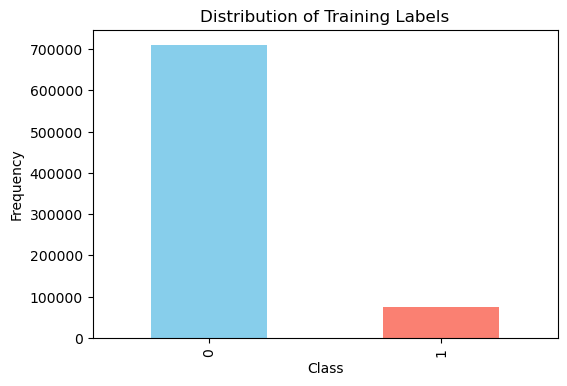

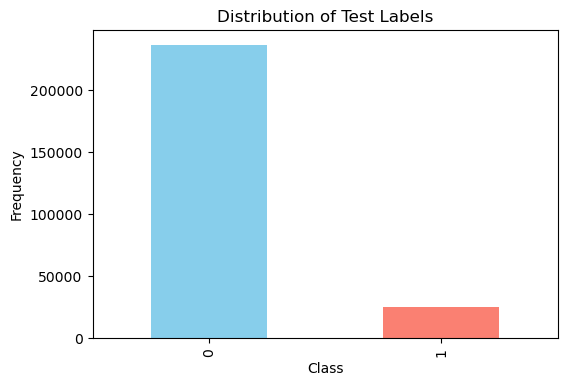

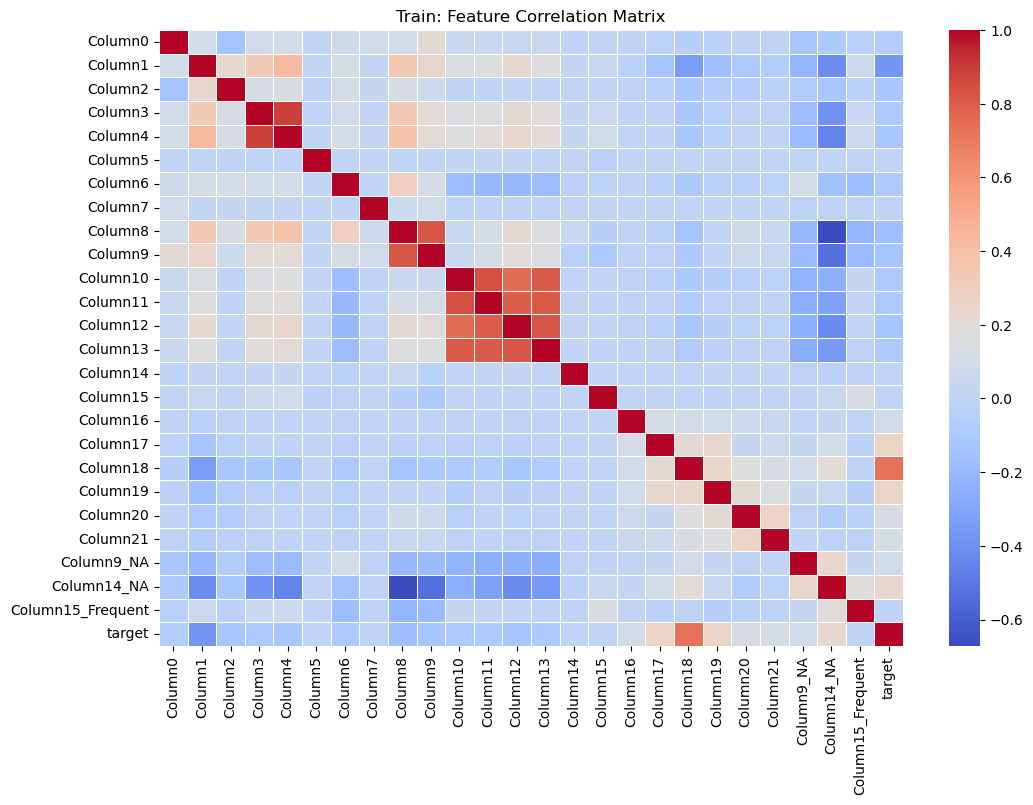

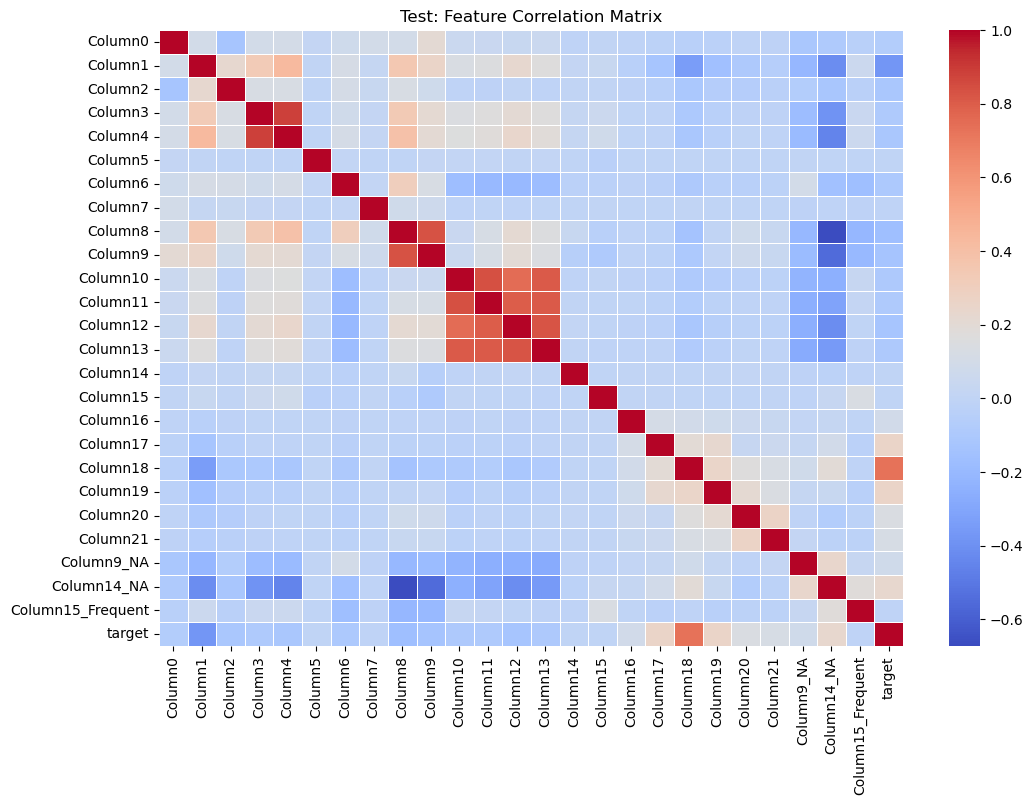

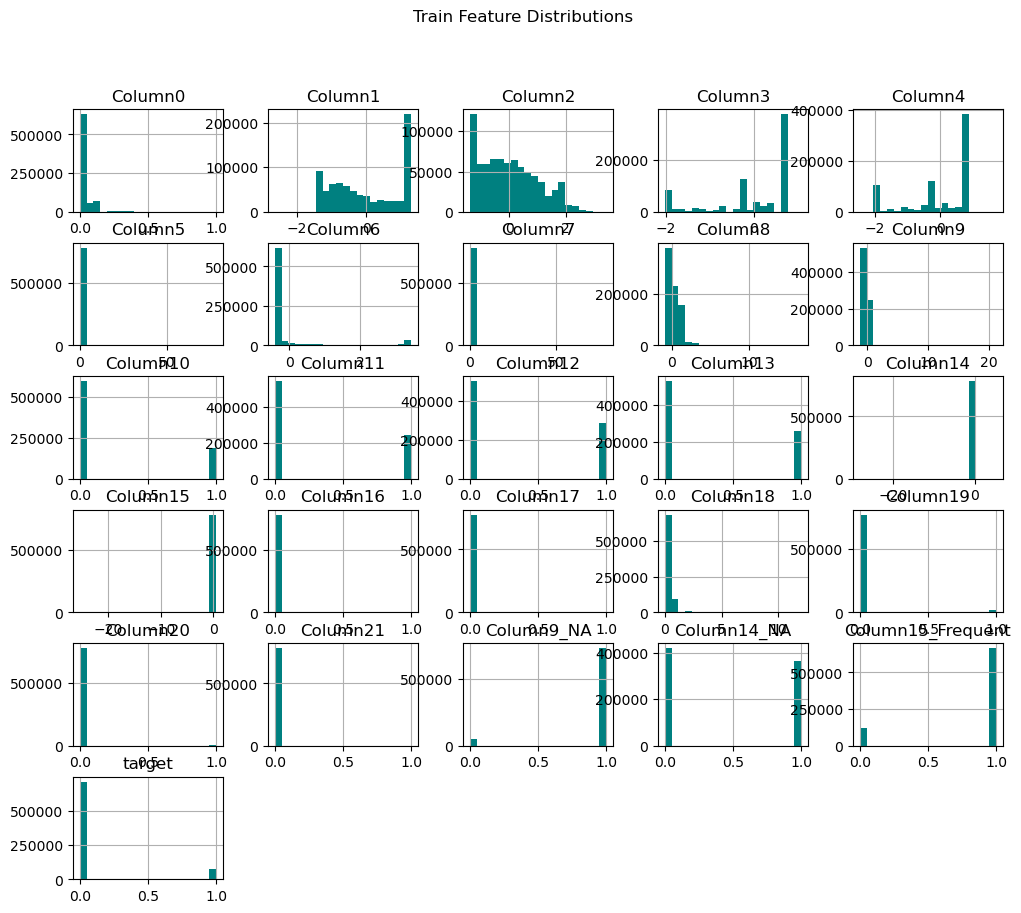

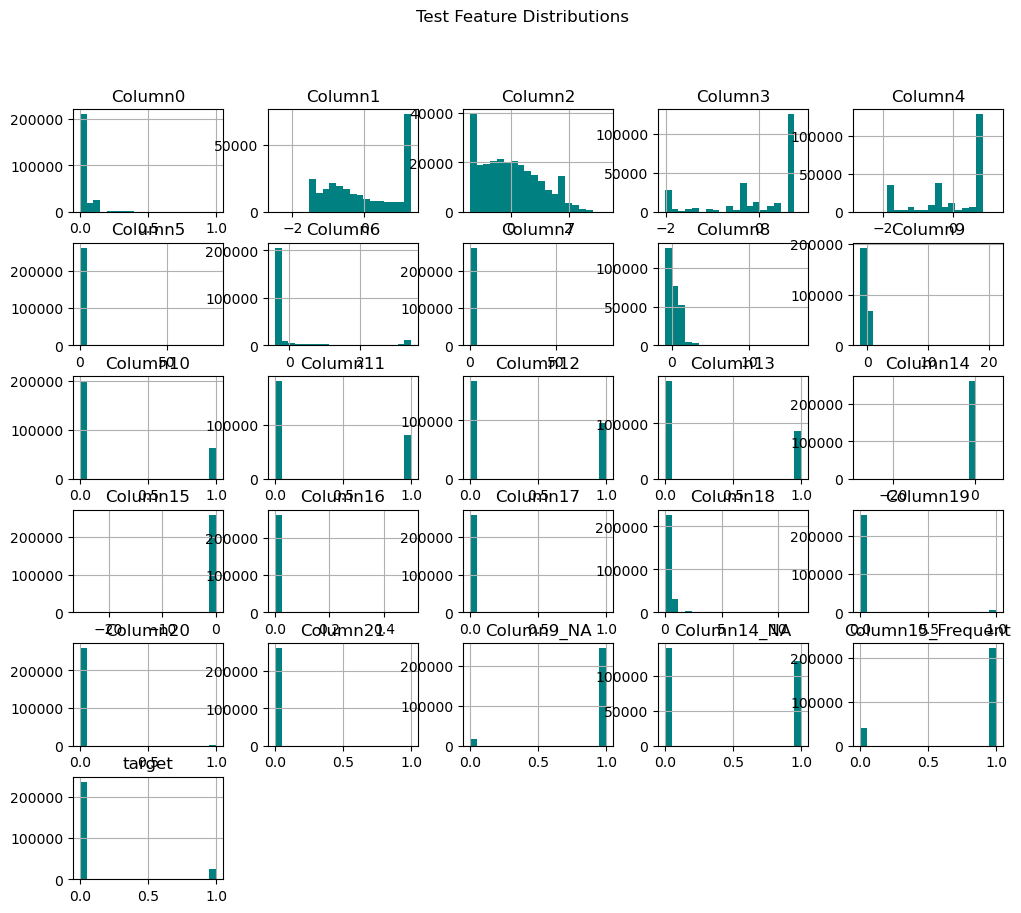

In [28]:
# Train: Visualize the distribution of the target labels in train dataset
plt.figure(figsize=(6,4))
combined_train['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Training Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Test: Visualize the distribution of the target labels in test dataset
plt.figure(figsize=(6,4))
combined_test['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Test Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Train: Visualizing the correlation matrix for numerical features (before handling missing values)
plt.figure(figsize=(12,8))
corr_matrix = combined_train.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Train: Feature Correlation Matrix")
plt.show()

# Test: Visualizing the correlation matrix for numerical features (before handling missing values)
plt.figure(figsize=(12,8))
corr_matrix = combined_test.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Test: Feature Correlation Matrix")
plt.show()


# Train: Visualize the distribution of each feature using histograms
combined_train.hist(figsize=(12,10), bins=20, color='teal')
plt.suptitle('Train Feature Distributions')
plt.show()

# Test: Visualize the distribution of each feature using histograms
combined_test.hist(figsize=(12,10), bins=20, color='teal')
plt.suptitle('Test Feature Distributions')
plt.show()

# 4. Model 1 (Robust to class 1)

Train a XGB Classifier such that the precision (from the view point of class 1) is high, so that the model robustly classifies class 1 (i.e. extremely low flase positives)

## 4.1. Build and Train the model

In [29]:
# Train XGBoost with class weights to make it robust on class '1' prediction.
model_1 = XGBClassifier(scale_pos_weight=(1/250), random_state=42, n_estimators=300)  # Adjust the weight ratio based on imbalance
model_1.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## 4.2. Save the model

In [30]:
# Save model for future predictions
model_1.save_model('tf_models/model_xgb_robust_class_1.json')

## 4.3. Load the model
If already trained, load that model

In [31]:
# Load the model
model_1 = XGBClassifier()
model_1.load_model('tf_models/model_xgb_robust_class_1.json')

## 4.4. Test the Model

Model 1 Accuracy: 91.52%

Confusion Matrix:
[[237020     14]
 [ 22171   2507]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.96    237034
           1       0.99      0.10      0.18     24678

    accuracy                           0.92    261712
   macro avg       0.95      0.55      0.57    261712
weighted avg       0.92      0.92      0.88    261712



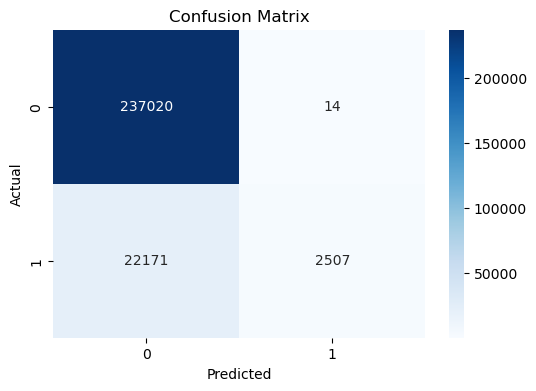

Precision: 0.99
Recall: 0.10
F1-Score: 0.18
ROC-AUC: 0.55


In [32]:
# Make predictions
Y_pred_1 = model_1.predict(X_test)

# Evaluate the model
accuracy_1 = accuracy_score(Y_test, Y_pred_1)
print(f"Model 1 Accuracy: {accuracy_1 * 100:.2f}%")

# Confusion matrix
cm_1 = confusion_matrix(Y_test, Y_pred_1)
print("\nConfusion Matrix:")
print(cm_1)

# Classification report for more detailed evaluation
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_1))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Precision, Recall, F1-Score
precision_1 = precision_score(Y_test, Y_pred_1)
recall_1 = recall_score(Y_test, Y_pred_1)
f1_1 = f1_score(Y_test, Y_pred_1)
roc_auc_1 = roc_auc_score(Y_test, Y_pred_1)

print(f"Precision: {precision_1:.2f}")
print(f"Recall: {recall_1:.2f}")
print(f"F1-Score: {f1_1:.2f}")
print(f"ROC-AUC: {roc_auc_1:.2f}")

# 5. Model 2 (Robust to class 0)

## 5.1. Build and Train the model

In [33]:
model_2 = Sequential()

# Input layer
model_2.add(Input(shape=(X_train.shape[1],)))

model_2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(Dropout(0.4))

model_2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(Dropout(0.4))  # Regularization

model_2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.4))

model_2.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))

# Output layer
model_2.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = Adam(learning_rate=0.001)
model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

2024-09-23 18:47:50.102283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6719 MB memory:  -> device: 0, name: NVIDIA T1000 8GB, pci bus id: 0000:af:00.0, compute capability: 7.5


In [34]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.5520552664885389, 1: 5.302588035065444}


In [ ]:
# Run Tensorboard to visualize the training progress
%tensorboard --logdir {'tf_logs/model_nn_robust_class_0'}

In [35]:
tensorboard_callback_model_2 = tf.keras.callbacks.TensorBoard(log_dir='tf_logs/model_nn_robust_class_0', histogram_freq=1)
lr_scheduler_model_2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model_2.fit(X_train, Y_train, 
          epochs=15, 
          batch_size=128, 
          validation_data=(X_test, Y_test), 
          callbacks=[tensorboard_callback_model_2, lr_scheduler_model_2],
          class_weight=class_weights
         )

Epoch 1/15


I0000 00:00:1727097491.288080  181185 service.cc:146] XLA service 0x7facd800e7f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727097491.288171  181185 service.cc:154]   StreamExecutor device (0): NVIDIA T1000 8GB, Compute Capability 7.5
2024-09-23 18:48:11.427786: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-23 18:48:11.760428: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   9/6134 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - AUC: 0.5683 - Precision: 0.1153 - Recall: 0.4547 - accuracy: 0.6254 - loss: 1.1068    

I0000 00:00:1727097495.730674  181185 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6134/6134 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - AUC: 0.9829 - Precision: 0.6648 - Recall: 0.9826 - accuracy: 0.9485 - loss: 0.2616 - val_AUC: 0.9916 - val_Precision: 0.7177 - val_Recall: 0.9984 - val_accuracy: 0.9628 - val_loss: 0.1265 - learning_rate: 0.0010
Epoch 2/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - AUC: 0.9901 - Precision: 0.7211 - Recall: 0.9985 - accuracy: 0.9632 - loss: 0.0915 - val_AUC: 0.9919 - val_Precision: 0.7222 - val_Recall: 0.9983 - val_accuracy: 0.9636 - val_loss: 0.1058 - learning_rate: 0.0010
Epoch 3/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - AUC: 0.9904 - Precision: 0.7171 - Recall: 0.9981 - accuracy: 0.9626 - loss: 0.0888 - val_AUC: 0.9921 - val_Precision: 0.7248 - val_Recall: 0.9989 - val_accuracy: 0.9641 - val_loss: 0.1034 - learning_rate: 0.0010
Epoch 4/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.9905 - Precision: 0.7240 - Recall: 0.9980 - accuracy: 0.9638 - loss: 0.0868 - val_AUC: 0.9920 - val_Precision: 0.7246 - val_Recall: 0.9998 -

## 5.2. Save the model

In [36]:
model_2.save('tf_models/model_nn_robust_class_0.keras') # For newer version of Tensorflow
model_2.save('tf_models/model_nn_robust_class_0.h5') # For older version of Tensorflow

## 5.3. Load the model
If already trained, load that model

In [37]:
model_2 = tf.keras.models.load_model('tf_models/model_nn_robust_class_0.keras')

## 5.4. Test the Model

In [38]:
Y_pred_prob_2 = model_2.predict(X_test)

8179/8179 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


In [39]:
Y_pred_2 = (Y_pred_prob_2 > 0.4).astype(int).flatten()

Model 2 Accuracy: 96.39%

Confusion Matrix:
[[227597   9437]
 [     2  24676]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    237034
           1       0.72      1.00      0.84     24678

    accuracy                           0.96    261712
   macro avg       0.86      0.98      0.91    261712
weighted avg       0.97      0.96      0.97    261712



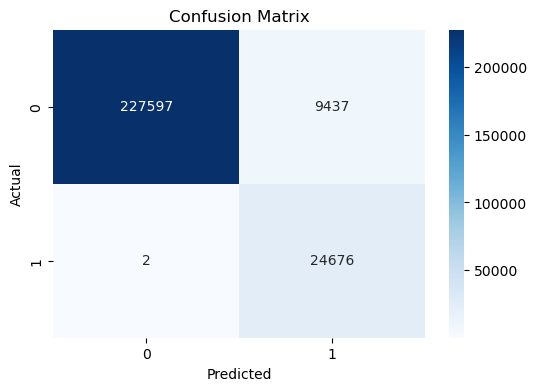

Precision: 0.72
Recall: 1.00
F1-Score: 0.84
ROC-AUC: 0.98


In [41]:
# Evaluate the model
accuracy_2 = accuracy_score(Y_test, Y_pred_2)
print(f"Model 2 Accuracy: {accuracy_2 * 100:.2f}%")

# Confusion matrix
cm_2 = confusion_matrix(Y_test, Y_pred_2)
print("\nConfusion Matrix:")
print(cm_2)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_2))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Precision, Recall, F1-Score
precision_2 = precision_score(Y_test, Y_pred_2)
recall_2 = recall_score(Y_test, Y_pred_2)
f1_2 = f1_score(Y_test, Y_pred_2)
roc_auc_2 = roc_auc_score(Y_test, Y_pred_2)

print(f"Precision: {precision_2:.2f}")
print(f"Recall: {recall_2:.2f}")
print(f"F1-Score: {f1_2:.2f}")
print(f"ROC-AUC: {roc_auc_2:.2f}")

# 6. Extract Probabilities from Model 1 and Model 2

In [42]:
preds_1_train = model_1.predict_proba(X_train)[:, 1] # Predicted probabilities for class 1
preds_2_train = model_2.predict(X_train)
 
# Stack predictions
preds_train = np.column_stack((preds_2_train, preds_1_train))

24536/24536 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step


In [43]:
pred_1_test = model_1.predict_proba(X_test)[:, 1]
pred_2_test = model_2.predict(X_test)

preds_test = np.column_stack((pred_2_test, pred_1_test))

8179/8179 ━━━━━━━━━━━━━━━━━━━━ 8s 990us/step


In [44]:
print(preds_train.shape)
print(preds_test.shape)

(785133, 2)
(261712, 2)


# 7. Meta Model (On top of Model 1 and Model 2)
Combine the Model 1 & Model 2

## 7.1. Build and Train the Meta Model

In [82]:
# Define the model
model_meta = Sequential()

model_meta.add(Input(shape=(preds_train.shape[1],)))

model_meta.add(Dense(8))
model_meta.add(LeakyReLU(alpha=0.1))

model_meta.add(Dense(4))
model_meta.add(LeakyReLU(alpha=0.1))

model_meta.add(Dense(1, activation='sigmoid'))

# Compile the model
model_meta.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Summary of the model
model_meta.summary()

/home/siddhesh/miniconda3/envs/env1/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65 (260.00 B)

 Trainable params: 65 (260.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Run Tensorboard to visualize the training progress
%load_ext tensorboard
%tensorboard --logdir {'tf_logs/model_meta_nn'}

In [83]:
tensorboard_callback_meta = tf.keras.callbacks.TensorBoard(log_dir='tf_logs/model_meta_nn', histogram_freq=1)
lr_scheduler_meta = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model_meta.fit(preds_train, Y_train, 
          epochs=15, 
          batch_size=128, 
          validation_data=(preds_test, Y_test), 
          callbacks=[tensorboard_callback_meta, lr_scheduler_meta]
         )

Epoch 1/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.9914 - Precision: 0.7911 - Recall: 0.9630 - accuracy: 0.9719 - loss: 0.1522 - val_AUC: 0.9945 - val_Precision: 0.8492 - val_Recall: 0.9211 - val_accuracy: 0.9771 - val_loss: 0.0551 - learning_rate: 0.0010
Epoch 2/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - AUC: 0.9949 - Precision: 0.8480 - Recall: 0.9177 - accuracy: 0.9769 - loss: 0.0500 - val_AUC: 0.9946 - val_Precision: 0.8550 - val_Recall: 0.9147 - val_accuracy: 0.9773 - val_loss: 0.0538 - learning_rate: 0.0010
Epoch 3/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.9951 - Precision: 0.8573 - Recall: 0.9118 - accuracy: 0.9774 - loss: 0.0486 - val_AUC: 0.9946 - val_Precision: 0.8500 - val_Recall: 0.9246 - val_accuracy: 0.9775 - val_loss: 0.0538 - learning_rate: 0.0010
Epoch 4/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.9953 - Precision: 0.8653 - Recall: 0.9054 - accuracy: 0.9778 - loss: 0.0482 - val_AUC: 0.9946 - val_Precision: 0.8430 - val_Recal

## 7.2. Save the Meta Model

In [91]:
model_meta.save('tf_models/model_meta_nn.keras')
model_meta.save('tf_models/model_meta_nn.h5')

## 7.3. Load the Meta Model
If already trained, load that model

In [92]:
model_meta = tf.keras.models.load_model('tf_models/model_meta_nn.keras')

## 7.4. Test the Meta Model

In [93]:
# Make predictions on the test set
Y_pred_prob = model_meta.predict(preds_test)

8179/8179 ━━━━━━━━━━━━━━━━━━━━ 8s 931us/step


In [94]:
Y_pred = (Y_pred_prob > 0.5).astype(int).flatten()

Meta Model Accuracy: 97.83%

Confusion Matrix:
[[233017   4017]
 [  1673  23005]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.85      0.93      0.89     24678

    accuracy                           0.98    261712
   macro avg       0.92      0.96      0.94    261712
weighted avg       0.98      0.98      0.98    261712



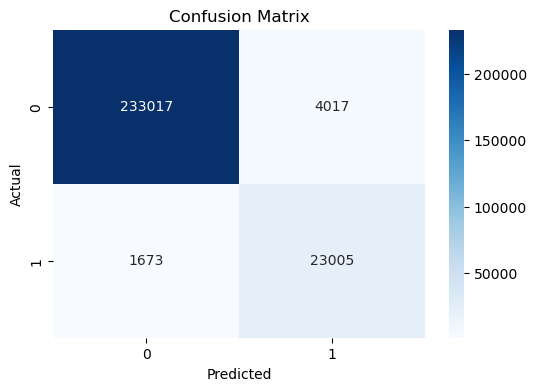

Precision: 0.85
Recall: 0.93
F1-Score: 0.89
ROC-AUC: 0.96


In [95]:
# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Meta Model Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Precision, Recall, F1-Score
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")